## Imports

In [3]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Extract data

In [4]:
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")


In [1]:
#print(os.listdir("train")) #just for checking

In [6]:
filenames = os.listdir("train")
labels = []
for filename in filenames:
    if "cat" in filename:
        labels.append('cat')
    elif "dog" in filename:
        labels.append('dog')
    
df = pd.DataFrame({
    'Filename': filenames,
    'Label': labels
})

df.head()

,Filename,Label
0,cat.9696.jpg,cat
1,cat.1256.jpg,cat
2,dog.3261.jpg,dog
3,cat.4729.jpg,cat
4,dog.11199.jpg,dog


It's good to see the data is shuffled

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  25000 non-null  object
 1   Label     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


We have 25,000 cat and 25,000 dog images.

## Display the images

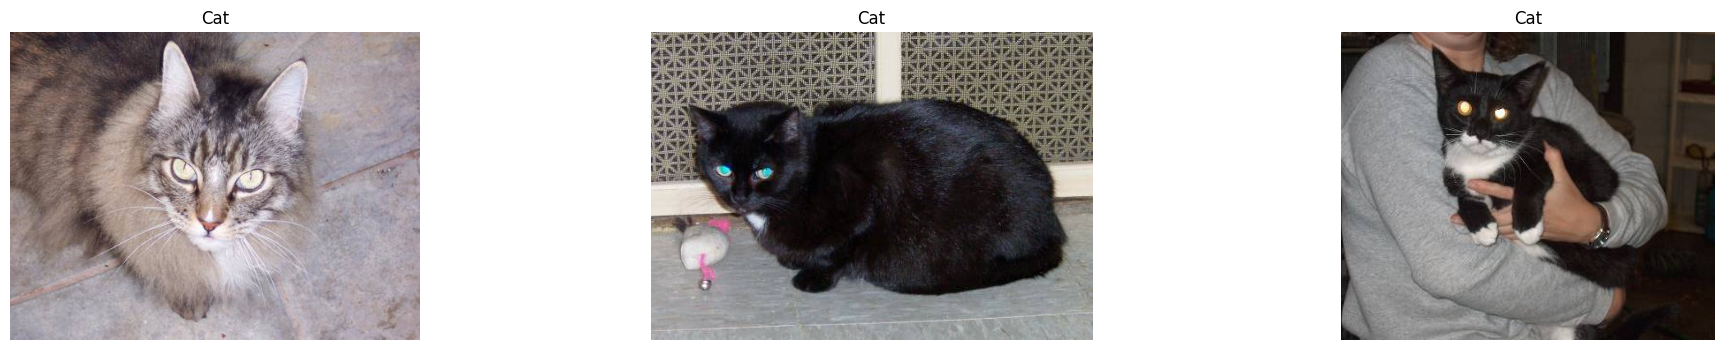

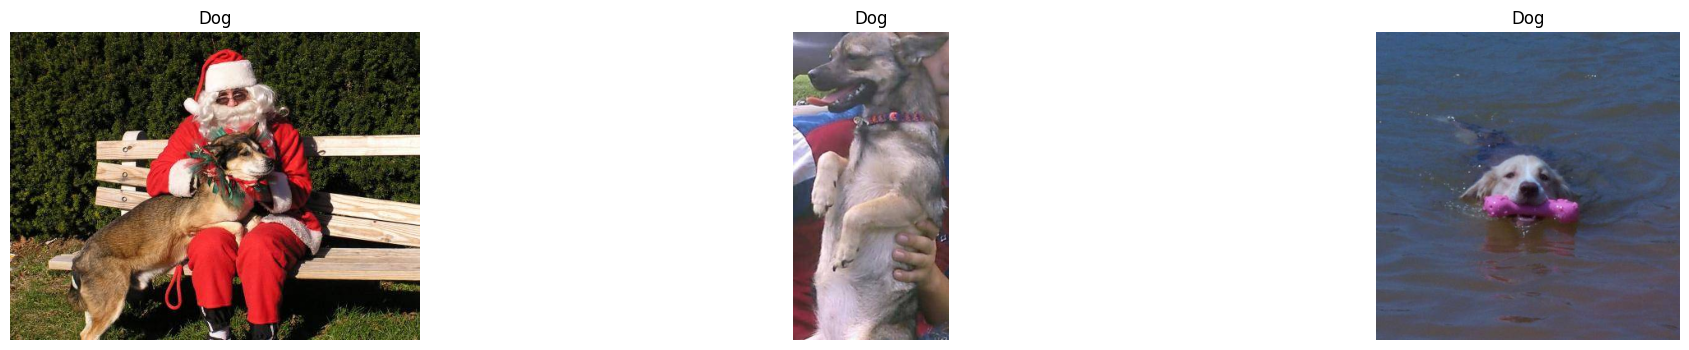

In [8]:
# Function to display images
def display_images(image_paths, category):
    plt.figure(figsize=(24, 4))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, 3, i + 1)
        img = mpimg.imread(os.path.join('train', img_path))
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Selecting three random images of cats
cat_images = [filename for filename in filenames if 'cat' in filename]
selected_cat_images = random.sample(cat_images, 3)

# Selecting three random images of dogs
dog_images = [filename for filename in filenames if 'dog' in filename]
selected_dog_images = random.sample(dog_images, 3)

# Display the images
display_images(selected_cat_images, 'Cat')
display_images(selected_dog_images, 'Dog')


## Data Prepration

In [9]:
# Constants
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32

In [10]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='train/',
    x_col='Filename',
    y_col='Label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='train/',
    x_col='Filename',
    y_col='Label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Load VGG Model

In [11]:
# Load the VGG16 model, pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
# Create the model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5
)

Epoch 1/5
625/625 [==============================] - 59s 87ms/step - loss: 0.3389 - accuracy: 0.8482 - val_loss: 0.2645 - val_accuracy: 0.8894
Epoch 2/5
625/625 [==============================] - 54s 86ms/step - loss: 0.2340 - accuracy: 0.9002 - val_loss: 0.2724 - val_accuracy: 0.8810
Epoch 3/5
625/625 [==============================] - 58s 92ms/step - loss: 0.1920 - accuracy: 0.9178 - val_loss: 0.2503 - val_accuracy: 0.8918
Epoch 4/5
625/625 [==============================] - 54s 87ms/step - loss: 0.1650 - accuracy: 0.9311 - val_loss: 0.2376 - val_accuracy: 0.9030
Epoch 5/5
625/625 [==============================] - 54s 86ms/step - loss: 0.1402 - accuracy: 0.9431 - val_loss: 0.2384 - val_accuracy: 0.9040


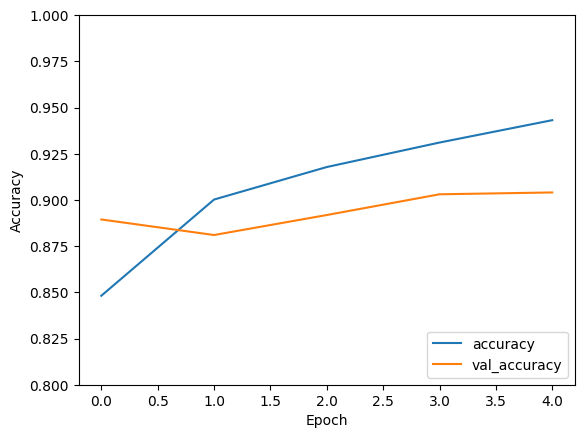

In [16]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

Validation accuracy started decreasing after a while. Let's try to train also some layers of VGG model.

In [17]:
#Unfreeze the last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5  # You can adjust the number of epochs
)

Epoch 1/5
625/625 [==============================] - 88s 133ms/step - loss: 0.2228 - accuracy: 0.9069 - val_loss: 0.1214 - val_accuracy: 0.9499
Epoch 2/5
625/625 [==============================] - 83s 132ms/step - loss: 0.0949 - accuracy: 0.9643 - val_loss: 0.0921 - val_accuracy: 0.9623
Epoch 3/5
625/625 [==============================] - 83s 133ms/step - loss: 0.0637 - accuracy: 0.9766 - val_loss: 0.0828 - val_accuracy: 0.9683
Epoch 4/5
625/625 [==============================] - 83s 132ms/step - loss: 0.0490 - accuracy: 0.9832 - val_loss: 0.0838 - val_accuracy: 0.9641
Epoch 5/5
625/625 [==============================] - 83s 132ms/step - loss: 0.0338 - accuracy: 0.9873 - val_loss: 0.0783 - val_accuracy: 0.9690


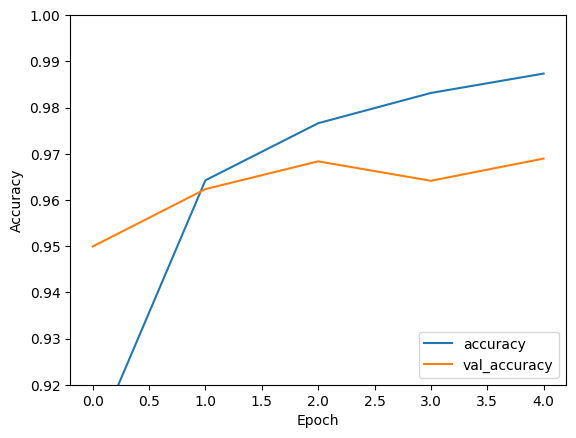

In [20]:
# Evaluate the model again
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.92, 1])
plt.legend(loc='lower right')

## Make Predictions with Test Data

In [21]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as test1_zip:
    test1_zip.extractall('.')  

In [22]:
test_dir = "../working/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"Filename": filenames})
test_data.head()

,Filename
0,1315.jpg
1,3255.jpg
2,7736.jpg
3,7594.jpg
4,3511.jpg


In [23]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    dataframe=test_data,
    directory='test1/',
    x_col='Filename',
    y_col=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
)

Found 12500 validated image filenames.


In [24]:
test1_predict = model.predict(test_generator)

391/391 [==============================] - 27s 68ms/step


In [25]:
test1_predict

array([[1.0000000e+00],
       [3.2349646e-02],
       [3.7635273e-13],
       ...,
       [1.3099831e-18],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [26]:
threshold = 0.5
test_data['Label'] = np.where(test1_predict > threshold, 'dog', 'cat')

In [29]:
test_data.tail()

,Filename,Label
12495,7249.jpg,dog
12496,11138.jpg,dog
12497,298.jpg,cat
12498,6177.jpg,dog
12499,6655.jpg,dog


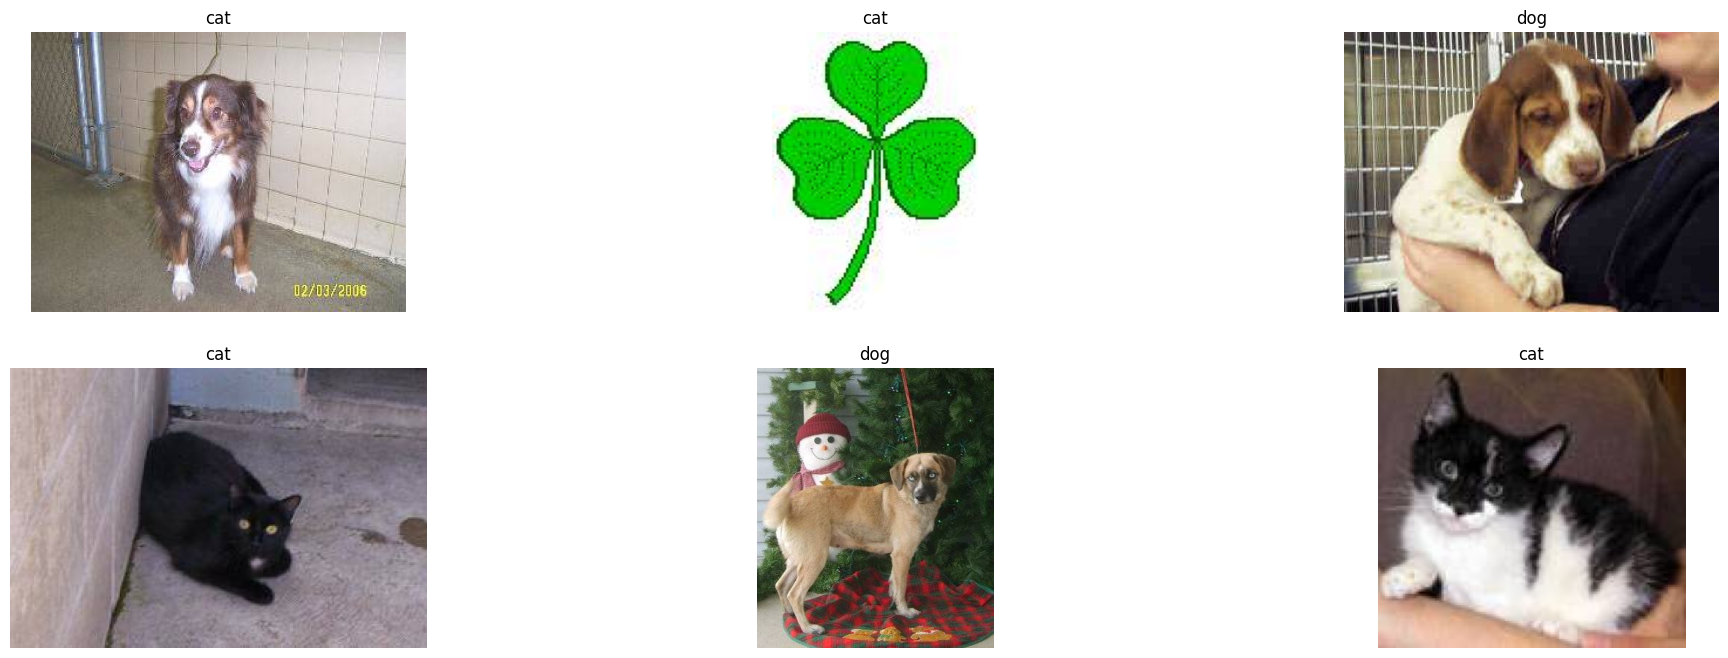

In [53]:
sample_test = test_data.sample(n=6)
plt.figure(figsize=(24, 8)) 

subplot_index = 1
for _, row in sample_test.iterrows():
    image_path = os.path.join(test_dir, row['Filename'])
    img = mpimg.imread(image_path)
    plt.subplot(2, 3, subplot_index)
    plt.imshow(img)
    plt.title(row['Label'])
    plt.axis('off')
    subplot_index += 1

plt.show()